#### Install Dependencies dan install pdfplumber

In [ ]:
!apt-get update -qq
!apt-get install -y -qq tesseract-ocr
!pip -q install pytesseract pillow

!pip install pdfplumber

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


####Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Ambil semua file (pdf/docx/txt) dari folder Data

In [ ]:
import os
from pathlib import Path
import pandas as pd

folder_path = Path("/content/drive/MyDrive/TUBES/S2-MKAB/Data")

print("Exists?", folder_path.exists())
print("Is dir?", folder_path.is_dir())

ext_ok = {".pdf", ".docx", ".txt"}
paths = []

for root, dirs, files in os.walk(folder_path):
    for f in files:
        p = Path(root) / f
        if p.suffix.lower() in ext_ok:
            paths.append(str(p))

paths = sorted(paths)
print("Jumlah file terbaca:", len(paths))
print("Contoh 10 file pertama:")
for p in paths[:10]:
    print("-", p)

df_files = pd.DataFrame({"path": paths})
df_files["ext"] = df_files["path"].apply(lambda x: Path(x).suffix.lower())
display(df_files["ext"].value_counts())


Exists? True
Is dir? True
Jumlah file terbaca: 21
Contoh 10 file pertama:
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/Kebijakan Strategis Ketahanan Pangan dan Gizi 2019 Badan Ketahanan Pangan Kementerian Pertanian.pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LAPORAN PENYELIDIKAN EPIDEMIOLOGI SEMENTARA 2022.pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LK Deputi Bid Pengawaan Pangan Olahan 2023 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT BPOM 2021.pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Layanan Informasi Publik 2016 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Layanan Informasi Publik 2017 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Layanan Informasi Publik 2019 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Layanan Informasi Publik 2023 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Layanan Informasi Publik 2024 (BPOM).pdf
- /content/drive/MyDrive/TUBES/S2-MKAB/Data/LT Pejabat Pengelola Informasi dan Dokumen

,count
ext,
.pdf,21


####Deteksi PDF “scan/gambar” vs “text-based”

In [ ]:
import pdfplumber
import pandas as pd
from pathlib import Path
from tqdm import tqdm

def detect_scanned_pdf(pdf_path: str, min_chars: int = 50):
    rows = []
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            text = page.extract_text() or ""
            rows.append({"page": i + 1, "text_chars": len(text.strip())})
    df = pd.DataFrame(rows)
    pct_low = (df["text_chars"] < min_chars).mean() * 100
    return df, pct_low

min_chars = 50
scan_threshold_pct = 70

summary_rows = []

pdf_paths = [p for p in paths if Path(p).suffix.lower() == ".pdf"]

for p in tqdm(pdf_paths, desc="Detecting scanned PDFs"):
    try:
        df_pages, pct_low = detect_scanned_pdf(p, min_chars=min_chars)
        summary_rows.append({
            "file": Path(p).name,
            "path": p,
            "n_pages": len(df_pages),
            "pct_low_text": round(pct_low, 2),
            "status": "LIKELY_SCANNED" if pct_low >= scan_threshold_pct else "TEXT_BASED"
        })
    except Exception as e:
        summary_rows.append({
            "file": Path(p).name,
            "path": p,
            "n_pages": None,
            "pct_low_text": None,
            "status": f"ERROR: {type(e).__name__}"
        })

df_summary = pd.DataFrame(summary_rows).sort_values(["status","pct_low_text"], ascending=[True, True])
display(df_summary)
print("Jumlah scanned:", (df_summary["status"]=="LIKELY_SCANNED").sum())


Detecting scanned PDFs: 100%|██████████| 21/21 [13:21<00:00, 38.15s/it]


,file,path,n_pages,pct_low_text,status
5,LT Layanan Informasi Publik 2017 (BPOM).pdf,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT L...,13,100.00,LIKELY_SCANNED
9,LT Pejabat Pengelola Informasi dan Dokumentasi...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...,39,100.00,LIKELY_SCANNED
17,Laporan Tahunan Direktorat Registrasi Pangan O...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,171,100.00,LIKELY_SCANNED
1,LAPORAN PENYELIDIKAN EPIDEMIOLOGI SEMENTARA 20...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LAPO...,11,0.00,TEXT_BASED
7,LT Layanan Informasi Publik 2023 (BPOM).pdf,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT L...,80,0.00,TEXT_BASED
10,LT Pejabat Pengelola Informasi dan Dokumentasi...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...,59,0.00,TEXT_BASED
11,LT Pengelolaan Informasi dan Dokumentasi 2021 ...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...,46,0.00,TEXT_BASED
12,LT Pengelolaan Informasi dan Dokumentasi 2022 ...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...,49,0.00,TEXT_BASED
14,Laporan Tahunan Balai Besar POM di Jakarta Tah...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,370,0.27,TEXT_BASED
15,Laporan Tahunan Direktorat Registrasi Pangan O...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,97,1.03,TEXT_BASED


Jumlah scanned: 3


####OCR hanya untuk PDF yang scanned (dan simpan txt)

In [ ]:
import pytesseract
from PIL import Image
from pathlib import Path

def ocr_pdf(pdf_path: str, dpi: int = 250) -> str:
    texts = []
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            pil_img = page.to_image(resolution=dpi).original
            txt = pytesseract.image_to_string(pil_img, config="--psm 6").strip()
            if txt:
                texts.append(f"\n\n=== PAGE {i+1} ===\n{txt}")
    return "\n".join(texts)

scanned_files = df_summary[df_summary["status"] == "LIKELY_SCANNED"].copy()
display(scanned_files[["file","n_pages","pct_low_text","path"]])

output_dir = Path("ocr_output")
output_dir.mkdir(exist_ok=True)

ocr_rows = []

for _, row in tqdm(scanned_files.iterrows(), total=len(scanned_files), desc="OCR scanned PDFs"):
    pdf_path = row["path"]
    stem = Path(pdf_path).stem
    out_txt = output_dir / f"{stem}_OCR.txt"

    if out_txt.exists():
        text_ocr = out_txt.read_text(encoding="utf-8", errors="ignore")
        source = "OCR_CACHE"
    else:
        text_ocr = ocr_pdf(pdf_path, dpi=250)
        out_txt.write_text(text_ocr, encoding="utf-8")
        source = "OCR_NEW"

    ocr_rows.append({
        "pdf_path": pdf_path,
        "pdf_file": Path(pdf_path).name,
        "ocr_txt_path": str(out_txt),
        "ocr_chars": len(text_ocr),
        "ocr_source": source
    })

df_ocr = pd.DataFrame(ocr_rows)
display(df_ocr)
print("OCR output folder:", output_dir)


,file,n_pages,pct_low_text,path
5,LT Layanan Informasi Publik 2017 (BPOM).pdf,13,100.0,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT L...
9,LT Pejabat Pengelola Informasi dan Dokumentasi...,39,100.0,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...
17,Laporan Tahunan Direktorat Registrasi Pangan O...,171,100.0,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...


OCR scanned PDFs: 100%|██████████| 3/3 [27:58<00:00, 559.53s/it]


,pdf_path,pdf_file,ocr_txt_path,ocr_chars,ocr_source
0,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT L...,LT Layanan Informasi Publik 2017 (BPOM).pdf,ocr_output/LT Layanan Informasi Publik 2017 (B...,20392,OCR_NEW
1,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LT P...,LT Pejabat Pengelola Informasi dan Dokumentasi...,ocr_output/LT Pejabat Pengelola Informasi dan ...,69314,OCR_NEW
2,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,Laporan Tahunan Direktorat Registrasi Pangan O...,ocr_output/Laporan Tahunan Direktorat Registra...,242293,OCR_NEW


OCR output folder: ocr_output


####Bangun Corpus FINAL (gabung PDF text + OCR + DOCX + TXT)

In [9]:
#from docx import Document

def read_pdf_text(pdf_path: str) -> str:
    texts = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            t = page.extract_text() or ""
            if t.strip():
                texts.append(t)
    return "\n".join(texts)

#def read_docx_text(docx_path: str) -> str:
 #   doc = Document(docx_path)
  #  paras = [p.text for p in doc.paragraphs if p.text.strip()]
   # return "\n".join(paras)

def read_txt_text(txt_path: str) -> str:
    return Path(txt_path).read_text(encoding="utf-8", errors="ignore")

# mapping pdf_path -> ocr_txt_path
ocr_map = {r["pdf_path"]: r["ocr_txt_path"] for _, r in df_ocr.iterrows()}

rows = []

for p in tqdm(paths, desc="Building final corpus"):
    p = str(p)
    ext = Path(p).suffix.lower()
    name = Path(p).name

    try:
        if ext == ".pdf":
            status = df_summary.loc[df_summary["path"] == p, "status"].iloc[0]
            if status == "LIKELY_SCANNED":
                raw_text = read_txt_text(ocr_map[p])
                source = "OCR_TEXT"
            else:
                raw_text = read_pdf_text(p)
                source = "PDF_TEXT"

        elif ext == ".docx":
            raw_text = read_docx_text(p)
            source = "DOCX_TEXT"
            status = "TEXT_BASED"

        elif ext == ".txt":
            raw_text = read_txt_text(p)
            source = "TXT"
            status = "TEXT_BASED"

        else:
            continue

        rows.append({
            "doc_name": name,
            "doc_path": p,
            "doc_ext": ext,
            "status": status,
            "source": source,
            "n_chars": len(raw_text),
            "raw_text": raw_text
        })

    except Exception as e:
        rows.append({
            "doc_name": name,
            "doc_path": p,
            "doc_ext": ext,
            "status": "ERROR",
            "source": f"ERROR: {type(e).__name__}",
            "n_chars": 0,
            "raw_text": ""
        })

df_corpus = pd.DataFrame(rows).sort_values("n_chars", ascending=False)
display(df_corpus[["doc_name","doc_ext","status","source","n_chars"]])

df_corpus.to_csv("corpus_all_docs.csv", index=False)
print("Saved: corpus_all_docs.csv")


Building final corpus: 100%|██████████| 21/21 [11:23<00:00, 32.55s/it]


,doc_name,doc_ext,status,source,n_chars
14,Laporan Tahunan Balai Besar POM di Jakarta Tah...,.pdf,TEXT_BASED,PDF_TEXT,644123
20,PPT-Laporan-Tahunan-Badan-POM-Tahun-2023.pdf,.pdf,TEXT_BASED,PDF_TEXT,576874
18,Laporan-Tahunan-Balai-Besar-POM-Di-Padang-Tahu...,.pdf,TEXT_BASED,PDF_TEXT,507998
2,LK Deputi Bid Pengawaan Pangan Olahan 2023 (BP...,.pdf,TEXT_BASED,PDF_TEXT,369439
13,Laporan Kinerja BPOM Tahun 2024.pdf,.pdf,TEXT_BASED,PDF_TEXT,337648
3,LT BPOM 2021.pdf,.pdf,TEXT_BASED,PDF_TEXT,305755
17,Laporan Tahunan Direktorat Registrasi Pangan O...,.pdf,LIKELY_SCANNED,OCR_TEXT,242293
8,LT Layanan Informasi Publik 2024 (BPOM).pdf,.pdf,TEXT_BASED,PDF_TEXT,184800
16,Laporan Tahunan Direktorat Registrasi Pangan O...,.pdf,TEXT_BASED,PDF_TEXT,177674
6,LT Layanan Informasi Publik 2019 (BPOM).pdf,.pdf,TEXT_BASED,PDF_TEXT,174238


Saved: corpus_all_docs.csv


####Quick sanity check (biar kamu yakin hasilnya “isi”, bukan noise)

In [10]:
# cek 1 contoh OCR doc
ocr_sample = df_corpus[df_corpus["source"]=="OCR_TEXT"].head(1)
if len(ocr_sample):
    print("=== OCR SAMPLE ===")
    print(ocr_sample.iloc[0]["doc_name"])
    print(ocr_sample.iloc[0]["raw_text"][:1200])

# cek 1 contoh PDF text doc
pdf_sample = df_corpus[df_corpus["source"]=="PDF_TEXT"].head(1)
if len(pdf_sample):
    print("\n=== PDF TEXT SAMPLE ===")
    print(pdf_sample.iloc[0]["doc_name"])
    print(pdf_sample.iloc[0]["raw_text"][:1200])


=== OCR SAMPLE ===
Laporan Tahunan Direktorat Registrasi Pangan Olahan Tahun 2024.pdf


=== PAGE 1 ===
wor
LAPORAN
TAHUNAN
2024
__ Direktorat Registrasi Pangan Olahan


=== PAGE 2 ===
KATA PENGANTAR
Segala puji dan syukur kami panjatkan kehadirat Tuhan yang Maha Esa,
-\ yang atas berkat, rahmat dan izin-Nya sehingga Laporan Tahunan 2024
q Direktorat Registrasi Pangan Olahan dapat terselesaikan.
Penyusunan laporan ini bertujuan untuk menyediakan informasi kepada
para pemangku kepentingan, serta memberikan gambaran bagi
pembaca seputar kegiatan yang ada pada Direktorat Registrasi Pangan
\ Olahan. Kritik dan saran yang membangun dari semua pihak sangat kami
harapkan demi pelaksanaan kegiatan Direktorat Registrasi Pangan
< $ r — Olahan yang lebih baik pada masa mendatang.
Peran Direktorat Registrasi Pangan Olahan sangat penting sebagai pengawasan pre-market,
pengawal kegiatan, dan legitimator program pembangunan keamanan pangan. Dalam laporan
ini, disampaikan hasil pelayanan publik dan keg

##implementasi pembersihan konten + segmentasi paragraf + metadata tagging (Python)

In [11]:
df_corpus_all = df_corpus

###Setup + Pola (regex) yang dipakai

In [12]:
import re
import pandas as pd
from pathlib import Path
from collections import Counter


###Fungsi pembersihan konten dokumen

####Hapus header/footer berulang (berbasis “line frequency”)

In [13]:
def remove_repeated_lines(text: str, min_repeat: int = 3, max_len: int = 80) -> str:
    """
    Menghapus baris yang berulang (header/footer) dengan menghitung frekuensi kemunculan baris.
    min_repeat: baris muncul >= ini dianggap boilerplate.
    max_len: header/footer biasanya pendek.
    """
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    if not lines:
        return text

    counts = Counter(lines)
    repeated = {ln for ln, c in counts.items() if c >= min_repeat and len(ln) <= max_len}

    cleaned = [ln for ln in lines if ln not in repeated]
    return "\n".join(cleaned)


####Hapus nomor halaman, “Halaman X”, “Page X”, dll

In [14]:
PAGE_PATTERNS = [
    r"\bhalaman\s*\d+\b",
    r"\bpage\s*\d+\b",
    r"\b\d+\s*/\s*\d+\b",   # 3/40
]

def remove_page_markers(text: str) -> str:
    t = text
    for pat in PAGE_PATTERNS:
        t = re.sub(pat, " ", t, flags=re.IGNORECASE)
    return t


####Hapus baris daftar isi (TOC-like)

In [15]:
def remove_toc_lines(text: str) -> str:
    """
    Menghapus baris yang mirip daftar isi:
    - Ada titik-titik panjang ....... 12
    - Ada 'Bab'/'Tabel'/'Gambar' diikuti nomor halaman
    """
    dotted = re.compile(r"\.{3,}\s*\d+\s*$")
    trailing_num = re.compile(r"\s+\d+\s*$")

    out = []
    for ln in text.splitlines():
        s = ln.strip()
        if not s:
            continue
        low = s.lower()

        if "daftar isi" in low or "table of contents" in low:
            continue
        if dotted.search(s):
            continue
        if len(s) <= 90 and trailing_num.search(s) and any(k in low for k in ["bab", "tabel", "gambar", "lampiran", "chapter"]):
            continue

        out.append(ln)
    return "\n".join(out)


####Pisahkan lampiran dari isi utama

In [16]:
ANNEX_HEADINGS = [
    r"\blampiran\b",
    r"\bappendix\b",
    r"\blamp\.\b",
]

def split_main_and_annex(text: str):
    low = text.lower()
    idxs = []
    for h in ANNEX_HEADINGS:
        m = re.search(h, low, flags=re.IGNORECASE)
        if m:
            idxs.append(m.start())
    if idxs:
        cut = min(idxs)
        return text[:cut].strip(), text[cut:].strip()
    return text.strip(), ""  # no annex found


####Hapus “tabel ASCII” (opsional)

In [17]:
def remove_table_like_blocks(text: str) -> str:
    """
    Menghapus baris yang terlihat seperti tabel teks:
    - Banyak tanda | atau ;
    - Banyak angka/kolom
    - Baris garis '----'
    """
    out = []
    for ln in text.splitlines():
        s = ln.strip()
        if not s:
            out.append("")
            continue

        # garis tabel
        if re.fullmatch(r"[-–—\s]{6,}", s):
            continue

        # banyak pemisah kolom
        if s.count("|") >= 3:
            continue

        # baris sangat numerik (mis. tabel angka)
        tokens = re.split(r"\s+", s)
        if len(tokens) >= 6:
            numish = sum(1 for tok in tokens if re.fullmatch(r"[\d.,%]+", tok or ""))
            if numish / len(tokens) >= 0.6:
                continue

        out.append(ln)
    return "\n".join(out)


####Normalisasi whitespace (rapihin)

In [18]:
def normalize_whitespace(text: str) -> str:
    t = text
    t = re.sub(r"[ \t]+", " ", t)
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()


###Segmentasi paragraf + metadata per paragraf

####Split paragraf

In [20]:
def split_paragraphs(text: str,
                     min_len: int = 30,
                     fallback_min_paragraphs: int = 5):
    """
    Adaptive paragraph splitter:
    1) Try split by double newline
    2) If too few paragraphs, fallback to newline-based grouping
    """

    # --- STEP 1: normal paragraph split ---
    paras = [p.strip() for p in re.split(r"\n\s*\n", text) if p.strip()]
    paras = [p for p in paras if len(p) >= min_len]

    # Kalau sudah cukup, langsung return
    if len(paras) >= fallback_min_paragraphs:
        return paras

    # --- STEP 2: FALLBACK split by single newline ---
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]

    merged = []
    buffer = ""

    for ln in lines:
        # gabungkan baris pendek agar jadi satu paragraf bermakna
        if len(buffer) < min_len:
            buffer = buffer + " " + ln if buffer else ln
        else:
            merged.append(buffer.strip())
            buffer = ln

    if buffer:
        merged.append(buffer.strip())

    # final filter
    merged = [p for p in merged if len(p) >= min_len]

    return merged


####ekstraksi metadata (heuristik dari nama file + isi)

In [21]:
def extract_year_or_date(doc_name: str, text: str):
    # cari yyyy dari nama file dulu
    m = re.search(r"(20\d{2})", doc_name)
    if m:
        return m.group(1)

    # cari tanggal format sederhana (dd-mm-yyyy / dd/mm/yyyy)
    m2 = re.search(r"\b(\d{1,2}[-/]\d{1,2}[-/](20\d{2}))\b", text)
    if m2:
        return m2.group(1)
    return None

def infer_jenis_laporan(doc_name: str, text: str):
    low = (doc_name + " " + text[:2000]).lower()
    if "kebijakan" in low or "strategis" in low or "peraturan" in low:
        return "dokumen_kebijakan"
    if "laporan tahunan" in low or "tahunan" in low:
        return "laporan_tahunan"
    if "pengawasan" in low:
        return "laporan_pengawasan"
    return "lainnya"

def infer_unit(doc_name: str, text: str):
    low = (doc_name + " " + text[:2000]).lower()
    # contoh unit (silakan kamu tambah sesuai dokumenmu)
    if "bpom" in low or "badan pom" in low:
        return "BPOM"
    if "badan pangan nasional" in low or "bapanas" in low:
        return "Bapanas"
    if "kemenkes" in low or "kementerian kesehatan" in low:
        return "Kemenkes"
    if "badan gizi nasional" in low or "bgn" in low:
        return "BGN"
    return "Unknown"

def make_doc_id(doc_path: str):
    # id sederhana dari nama file (aman & traceable)
    p = Path(doc_path)
    return p.stem


###Redaksi data sensitif (basic)

In [22]:
PHONE_RE = re.compile(r"(\+?62|0)\s*8\d{2}[\s\-]?\d{3,4}[\s\-]?\d{3,4}\b")
EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
COORD_RE = re.compile(r"\b-?\d{1,3}\.\d+\s*,\s*-?\d{1,3}\.\d+\b")  # lat,long

# Nama orang itu susah 100% tanpa NER. Kita buat heuristic aman:
# hapus pola "Nama: XXX" / "Petugas: XXX"
NAME_LABEL_RE = re.compile(r"\b(nama|petugas|kontak)\s*:\s*([A-Za-z .'-]{3,})", re.IGNORECASE)

def redact_sensitive(text: str) -> str:
    t = text
    t = PHONE_RE.sub("[REDACTED_PHONE]", t)
    t = EMAIL_RE.sub("[REDACTED_EMAIL]", t)
    t = COORD_RE.sub("[REDACTED_COORD]", t)
    t = NAME_LABEL_RE.sub(lambda m: f"{m.group(1)}: [REDACTED_NAME]", t)
    return t


###Jalankan pipeline ke df_corpus_all → hasil paragraf + metadata

In [23]:
def clean_and_structure_docs(df_corpus_all: pd.DataFrame,
                             remove_tables: bool = True,
                             header_min_repeat: int = 3):
    doc_rows = []
    para_rows = []

    for _, r in df_corpus_all.iterrows():
        doc_name = r["doc_name"]
        doc_path = r.get("doc_path", "")
        raw = r["raw_text"] or ""

        # --- Content cleaning ---
        t = raw
        t = remove_toc_lines(t)
        t = remove_page_markers(t)
        t = remove_repeated_lines(t, min_repeat=header_min_repeat)

        if remove_tables:
            t = remove_table_like_blocks(t)

        main_text, annex_text = split_main_and_annex(t)

        # --- Redaction (ethics) ---
        main_text = redact_sensitive(main_text)
        annex_text = redact_sensitive(annex_text)

        main_text = normalize_whitespace(main_text)
        annex_text = normalize_whitespace(annex_text)

        # --- Metadata ---
        tanggal = extract_year_or_date(doc_name, main_text)  # bisa year atau tanggal
        unit = infer_unit(doc_name, main_text)
        jenis = infer_jenis_laporan(doc_name, main_text)
        doc_id = make_doc_id(doc_path if doc_path else doc_name)

        # simpan dok level
        doc_rows.append({
            "id_dokumen": doc_id,
            "doc_name": doc_name,
            "doc_path": doc_path,
            "tanggal": tanggal,
            "unit": unit,
            "jenis_laporan": jenis,
            "main_chars": len(main_text),
            "annex_chars": len(annex_text),
        })

        # --- Paragraph split ---
        paras = split_paragraphs(main_text, min_len=80)
        for i, ptxt in enumerate(paras):
            para_rows.append({
                "id_dokumen": doc_id,
                "par_id": i,
                "tanggal": tanggal,
                "unit": unit,
                "jenis_laporan": jenis,
                "paragraf_raw": ptxt,
                "paragraf_chars": len(ptxt),
            })

    df_docs_clean = pd.DataFrame(doc_rows)
    df_paras = pd.DataFrame(para_rows)
    return df_docs_clean, df_paras

df_docs_clean, df_paras = clean_and_structure_docs(df_corpus_all, remove_tables=True, header_min_repeat=3)

print("Dokumen summary:", df_docs_clean.shape)
print("Paragraf corpus:", df_paras.shape)
display(df_docs_clean.head())
display(df_paras.head(10))


Dokumen summary: (21, 8)
Paragraf corpus: (6394, 7)


,id_dokumen,doc_name,doc_path,tanggal,unit,jenis_laporan,main_chars,annex_chars
0,Laporan Tahunan Balai Besar POM di Jakarta Tah...,Laporan Tahunan Balai Besar POM di Jakarta Tah...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,2023,BPOM,laporan_tahunan,2044,530839
1,PPT-Laporan-Tahunan-Badan-POM-Tahun-2023,PPT-Laporan-Tahunan-Badan-POM-Tahun-2023.pdf,/content/drive/MyDrive/TUBES/S2-MKAB/Data/PPT-...,2023,BPOM,dokumen_kebijakan,146866,379787
2,Laporan-Tahunan-Balai-Besar-POM-Di-Padang-Tahu...,Laporan-Tahunan-Balai-Besar-POM-Di-Padang-Tahu...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,2023,BPOM,laporan_tahunan,4810,436619
3,LK Deputi Bid Pengawaan Pangan Olahan 2023 (BPOM),LK Deputi Bid Pengawaan Pangan Olahan 2023 (BP...,/content/drive/MyDrive/TUBES/S2-MKAB/Data/LK D...,2023,BPOM,dokumen_kebijakan,2175,317424
4,Laporan Kinerja BPOM Tahun 2024,Laporan Kinerja BPOM Tahun 2024.pdf,/content/drive/MyDrive/TUBES/S2-MKAB/Data/Lapo...,2024,BPOM,dokumen_kebijakan,33461,269897


,id_dokumen,par_id,tanggal,unit,jenis_laporan,paragraf_raw,paragraf_chars
0,Laporan Tahunan Balai Besar POM di Jakarta Tah...,0,2023,BPOM,laporan_tahunan,LAPORAN TAHUNAN Balai Besar Pengawas Obat dan ...,103
1,Laporan Tahunan Balai Besar POM di Jakarta Tah...,1,2023,BPOM,laporan_tahunan,Puji Syukur kami panjatkan ke hadirat Allah SW...,122
2,Laporan Tahunan Balai Besar POM di Jakarta Tah...,2,2023,BPOM,laporan_tahunan,kesempatan untuk menorehkan karya setahun kami...,112
3,Laporan Tahunan Balai Besar POM di Jakarta Tah...,3,2023,BPOM,laporan_tahunan,Laporan Tahunan. Laporan Tahunan Balai Besar P...,125
4,Laporan Tahunan Balai Besar POM di Jakarta Tah...,4,2023,BPOM,laporan_tahunan,tugas dan fungsi BBPOM di Jakarta. Laporan ini...,122
5,Laporan Tahunan Balai Besar POM di Jakarta Tah...,5,2023,BPOM,laporan_tahunan,pengawasan obat dan makanan di wilayah Provins...,180
6,Laporan Tahunan Balai Besar POM di Jakarta Tah...,6,2023,BPOM,laporan_tahunan,mitra lintas sektor serta peran serta masyarak...,99
7,Laporan Tahunan Balai Besar POM di Jakarta Tah...,7,2023,BPOM,laporan_tahunan,semua pihak yang telah memberikan kontribusi t...,98
8,Laporan Tahunan Balai Besar POM di Jakarta Tah...,8,2023,BPOM,laporan_tahunan,ini. Kami menyadari bahwa penyajian Laporan Ta...,99
9,Laporan Tahunan Balai Besar POM di Jakarta Tah...,9,2023,BPOM,laporan_tahunan,dan saran dari berbagai pihak sangat kami hara...,93


In [24]:
print(df_paras.shape)


(6394, 7)


###Pipeline NLP PRe Processing

#### install

In [25]:
!pip -q install Sastrawi scikit-learn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.9 MB/s eta 0:00:00


####Preprocessing: clean + stopword + stemming

In [26]:
import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Stemmer ID
stemmer = StemmerFactory().create_stemmer()

# Stopwords minimal (boleh kamu tambah)
STOPWORDS_ID = set("""
yang dan di ke dari untuk pada dalam dengan sebagai atau serta karena agar maka
ini itu tersebut adalah ialah yaitu oleh bila jika namun tetapi
dalamnya terhadap sehingga melalui serta
""".split())

def preprocess_id(text: str, keep_numbers: bool = True) -> str:
    """
    Minimal preprocessing untuk Bahasa Indonesia:
    - lowercase
    - remove url
    - keep letters (+ optionally numbers)
    - stopword removal
    - stemming
    """
    if text is None:
        return ""
    t = text.lower()
    t = re.sub(r"http\S+|www\S+", " ", t)

    if keep_numbers:
        t = re.sub(r"[^0-9a-zA-ZÀ-ÿ\u00C0-\u024F\u1E00-\u1EFF\s]", " ", t)
    else:
        t = re.sub(r"[^a-zA-ZÀ-ÿ\u00C0-\u024F\u1E00-\u1EFF\s]", " ", t)

    t = re.sub(r"\s+", " ", t).strip()

    tokens = [w for w in t.split() if w not in STOPWORDS_ID and len(w) > 2]
    t2 = " ".join(tokens)

    # stemming
    return stemmer.stem(t2)

# Apply ke paragraf
df_paras = df_paras.copy()
df_paras["paragraf_clean"] = df_paras["paragraf_raw"].apply(lambda x: preprocess_id(x, keep_numbers=True))

df_paras[["paragraf_raw","paragraf_clean"]].head(3)


,paragraf_raw,paragraf_clean
0,LAPORAN TAHUNAN Balai Besar Pengawas Obat dan ...,lapor tahun balai besar awas obat makan jakart...
1,Puji Syukur kami panjatkan ke hadirat Allah SW...,puji syukur kami panjat hadirat allah swt atas...
2,kesempatan untuk menorehkan karya setahun kami...,sempat toreh karya tahun kami laksana tugas fu...


####TF-IDF Keywords (top terms)

Kenapa tidak BERT?
Karena tujuan penelitian ini adalah eksplorasi tematik dan klasifikasi konseptual PESTLE, pendekatan berbasis TF-IDF dan topic modeling dinilai lebih transparan dan mudah diinterpretasikan. Penggunaan embedding kontekstual seperti BERT lebih relevan untuk klasifikasi supervised dengan data berlabel, yang berada di luar cakupan penelitian ini.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def top_keywords_tfidf(texts, top_n=30):
    vect = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
    X = vect.fit_transform(texts)
    terms = vect.get_feature_names_out()
    scores = np.asarray(X.mean(axis=0)).ravel()
    top_idx = scores.argsort()[::-1][:top_n]
    return pd.DataFrame({"term": terms[top_idx], "score": scores[top_idx]}), vect, X

df_kw, tfidf_vect, X_tfidf = top_keywords_tfidf(df_paras["paragraf_clean"], top_n=40)
display(df_kw.head(20))


,term,score
0,pangan,0.023908
1,tahun,0.020682
2,pom,0.016912
3,bpom,0.016862
4,registrasi,0.016331
5,olah,0.016275
6,obat,0.016156
7,pangan olah,0.014834
8,informasi,0.014750
9,laku,0.013658


####Topic Modeling (LDA) — tema dominan

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def run_lda_topics(texts, n_topics=6, n_top_words=10):
    cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
    X = cv.fit_transform(texts)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(X)

    vocab = cv.get_feature_names_out()
    topics = []
    for k, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[::-1][:n_top_words]
        topics.append({
            "topic": k,
            "top_words": ", ".join(vocab[top_idx])
        })

    return pd.DataFrame(topics), lda, cv, X

df_topics, lda_model, count_vect, X_counts = run_lda_topics(df_paras["paragraf_clean"], n_topics=6, n_top_words=12)
display(df_topics)


,topic,top_words
0,0,"cid, cid cid, eee, 000, cece, pegawai, eee eee..."
1,1,"informasi, publik, giat, obat, laku, edar, lak..."
2,2,"pangan, olah, registrasi, pangan olah, 171, ci..."
3,3,"tahun, bpom, obat, makan, kerja, lapor, awas, ..."
4,4,"pangan, laku, dapat, usaha, olah, registrasi, ..."
5,5,"pom, badan pom, badan, balai, besar, loka, lok..."


#####(Opsional) Assign top topic per paragraf

In [29]:
topic_dist = lda_model.transform(X_counts)  # shape: (n_paragraphs, n_topics)
df_paras["topic_id"] = topic_dist.argmax(axis=1)
df_paras["topic_score"] = topic_dist.max(axis=1)

df_paras[["id_dokumen","par_id","topic_id","topic_score"]].head()


,id_dokumen,par_id,topic_id,topic_score
0,Laporan Tahunan Balai Besar POM di Jakarta Tah...,0,3,0.763020
1,Laporan Tahunan Balai Besar POM di Jakarta Tah...,1,4,0.960282
2,Laporan Tahunan Balai Besar POM di Jakarta Tah...,2,3,0.894318
3,Laporan Tahunan Balai Besar POM di Jakarta Tah...,3,3,0.678173
4,Laporan Tahunan Balai Besar POM di Jakarta Tah...,4,3,0.955626


###Klasifikasi PESTLE per paragraf (rule-based baseline)

In [30]:
PESTLE_KEYWORDS = {
    "Political": [
        "kebijakan","program","pemerintah","koordinasi","strategi","anggaran","nasional","daerah"
    ],
    "Economic": [
        "harga","biaya","pasokan","distribusi","rantai","supply","inflasi","subsidi","logistik"
    ],
    "Social": [
        "masyarakat","konsumen","kesehatan","edukasi","literasi","perilaku","komunitas","anak","sekolah"
    ],
    "Technological": [
        "teknologi","sistem","digital","aplikasi","data","laboratorium","monitoring","otomasi","platform"
    ],
    "Legal": [
        "regulasi","aturan","undang","peraturan","standar","sanksi","kepatuhan","sertifikasi","perizinan"
    ],
    "Environmental": [
        "lingkungan","sanitasi","limbah","iklim","cuaca","kontaminasi","mikroba","higien","air"
    ],
}

def pestle_rule_label(sentence_clean: str) -> str:
    scores = {k: 0 for k in PESTLE_KEYWORDS}
    for cat, kws in PESTLE_KEYWORDS.items():
        for kw in kws:
            if kw in sentence_clean:
                scores[cat] += 1
    best = max(scores, key=scores.get)
    return best if scores[best] > 0 else "Uncategorized"

df_paras["pestle"] = df_paras["paragraf_clean"].apply(pestle_rule_label)

# Distribusi PESTLE
pestle_dist = df_paras["pestle"].value_counts().reset_index()
pestle_dist.columns = ["pestle","count"]
display(pestle_dist)


,pestle,count
0,Uncategorized,4489
1,Technological,585
2,Political,469
3,Social,301
4,Legal,256
5,Economic,224
6,Environmental,70


#####Contoh paragraf per kategori (buat PPT/paper)

In [31]:
cols = ["pestle","doc_name","tanggal","unit","jenis_laporan","paragraf_raw"]
cols_exist = [c for c in cols if c in df_paras.columns]

samples = (df_paras[df_paras["pestle"] != "Uncategorized"]
           .groupby("pestle")
           .head(3)[cols_exist])

display(samples)

print("Dipakai:", cols_exist)
print("Tidak ada:", [c for c in cols if c not in df_paras.columns])


,pestle,tanggal,unit,jenis_laporan,paragraf_raw
6,Social,2023,BPOM,laporan_tahunan,mitra lintas sektor serta peran serta masyarak...
10,Technological,2023,BPOM,laporan_tahunan,mendatang. Semoga Laporan Tahunan ini dapat me...
11,Political,2023,BPOM,laporan_tahunan,"peningkatan kualitas kinerja, penyusunan progr..."
22,Political,2023,BPOM,dokumen_kebijakan,wujud pertanggungjawaban BPOM dalam pelaksanaa...
24,Political,2023,BPOM,dokumen_kebijakan,yang harus dilakukan oleh BPOM. Jejaring kerja...
29,Legal,2023,BPOM,dokumen_kebijakan,dan prasarana yang memadai. Pencapaian BPOM di...
31,Technological,2023,BPOM,dokumen_kebijakan,pengujian laboratorium produk Obat dan Makanan...
32,Economic,2023,BPOM,dokumen_kebijakan,dan distribusi dalam rangka pengawasan impleme...
35,Social,2023,BPOM,dokumen_kebijakan,2023 BPOM tetap berupaya melakukan pemberdayaa...
39,Social,2023,BPOM,dokumen_kebijakan,masyarakat terhadap peredaran Obat dan Makanan...


Dipakai: ['pestle', 'tanggal', 'unit', 'jenis_laporan', 'paragraf_raw']
Tidak ada: ['doc_name']


###Simpan hasil (biar aman)

In [32]:
df_paras.to_csv("paragraphs_with_nlp_pestle.csv", index=False)
df_kw.to_csv("tfidf_keywords.csv", index=False)
df_topics.to_csv("lda_topics.csv", index=False)

print("Saved: paragraphs_with_nlp_pestle.csv, tfidf_keywords.csv, lda_topics.csv")


Saved: paragraphs_with_nlp_pestle.csv, tfidf_keywords.csv, lda_topics.csv


####lihat hasil

In [33]:
import pandas as pd
pd.read_csv("/content/paragraphs_with_nlp_pestle.csv").head()


,id_dokumen,par_id,tanggal,unit,jenis_laporan,paragraf_raw,paragraf_chars,paragraf_clean,topic_id,topic_score,pestle
0,Laporan Tahunan Balai Besar POM di Jakarta Tah...,0,2023,BPOM,laporan_tahunan,LAPORAN TAHUNAN Balai Besar Pengawas Obat dan ...,103,lapor tahun balai besar awas obat makan jakart...,3,0.763020,Uncategorized
1,Laporan Tahunan Balai Besar POM di Jakarta Tah...,1,2023,BPOM,laporan_tahunan,Puji Syukur kami panjatkan ke hadirat Allah SW...,122,puji syukur kami panjat hadirat allah swt atas...,4,0.960282,Uncategorized
2,Laporan Tahunan Balai Besar POM di Jakarta Tah...,2,2023,BPOM,laporan_tahunan,kesempatan untuk menorehkan karya setahun kami...,112,sempat toreh karya tahun kami laksana tugas fu...,3,0.894318,Uncategorized
3,Laporan Tahunan Balai Besar POM di Jakarta Tah...,3,2023,BPOM,laporan_tahunan,Laporan Tahunan. Laporan Tahunan Balai Besar P...,125,lapor tahun lapor tahun balai besar pom jakart...,3,0.678173,Uncategorized
4,Laporan Tahunan Balai Besar POM di Jakarta Tah...,4,2023,BPOM,laporan_tahunan,tugas dan fungsi BBPOM di Jakarta. Laporan ini...,122,tugas fungsi bbpom jakarta lapor juga beri inf...,3,0.955626,Uncategorized


#####disimpan ke gdrive

In [34]:
save_dir = "/content/drive/MyDrive/TUBES/S2-MKAB/TUBES_NLP_PESTLE_OUTPUT"
import os
os.makedirs(save_dir, exist_ok=True)

df_paras.to_csv(f"{save_dir}/paragraphs_with_nlp_pestle.csv", index=False)
df_kw.to_csv(f"{save_dir}/tfidf_keywords.csv", index=False)
df_topics.to_csv(f"{save_dir}/lda_topics.csv", index=False)

print("Saved to Google Drive:", save_dir)


Saved to Google Drive: /content/drive/MyDrive/TUBES/S2-MKAB/TUBES_NLP_PESTLE_OUTPUT


### Model Klasifikasi PESTLE

In [35]:
# pastikan kamus PESTLE yang sama dipakai
PESTLE_KEYWORDS = {
    "Political": ["kebijakan","program","pemerintah","koordinasi","strategi","anggaran","nasional","daerah"],
    "Economic": ["harga","biaya","pasokan","distribusi","rantai","supply","inflasi","subsidi","logistik"],
    "Social": ["masyarakat","konsumen","kesehatan","edukasi","literasi","perilaku","komunitas","anak","sekolah"],
    "Technological": ["teknologi","sistem","digital","aplikasi","data","laboratorium","monitoring","otomasi","platform"],
    "Legal": ["regulasi","aturan","undang","peraturan","standar","sanksi","kepatuhan","sertifikasi","perizinan"],
    "Environmental": ["lingkungan","sanitasi","limbah","iklim","cuaca","kontaminasi","mikroba","higien","air"],
}

def pestle_confidence(text_clean, label):
    kws = PESTLE_KEYWORDS.get(label, [])
    return sum(1 for kw in kws if kw in text_clean)

df_paras["pestle_confidence"] = df_paras.apply(
    lambda r: pestle_confidence(r["paragraf_clean"], r["pestle"]),
    axis=1
)


In [36]:
display(pestle_confidence)

<function __main__.pestle_confidence(text_clean, label)>

In [37]:
pestle_global = (
    df_paras["pestle"]
    .value_counts()
    .reset_index()
    .rename(columns={"index":"pestle","pestle":"count"})
)

display(pestle_global)


,count,count
0,Uncategorized,4489
1,Technological,585
2,Political,469
3,Social,301
4,Legal,256
5,Economic,224
6,Environmental,70


In [38]:
pestle_per_doc = (
    df_paras
    .groupby(["id_dokumen","pestle"])
    .size()
    .reset_index(name="count")
)

display(pestle_per_doc.head())


,id_dokumen,pestle,count
0,Kebijakan Strategis Ketahanan Pangan dan Gizi ...,Economic,42
1,Kebijakan Strategis Ketahanan Pangan dan Gizi ...,Environmental,15
2,Kebijakan Strategis Ketahanan Pangan dan Gizi ...,Legal,8
3,Kebijakan Strategis Ketahanan Pangan dan Gizi ...,Political,77
4,Kebijakan Strategis Ketahanan Pangan dan Gizi ...,Social,58


In [39]:
pestle_per_unit = (
    df_paras
    .groupby(["unit","pestle"])
    .size()
    .reset_index(name="count")
)

display(pestle_per_unit)


,unit,pestle,count
0,BGN,Economic,10
1,BGN,Environmental,10
2,BGN,Legal,7
3,BGN,Political,30
4,BGN,Social,8
5,BGN,Technological,5
6,BGN,Uncategorized,43
7,BPOM,Economic,119
8,BPOM,Environmental,21
9,BPOM,Legal,199


In [40]:
# pastikan 'tanggal' berisi tahun (string atau int)
df_paras["tahun"] = df_paras["tanggal"].astype(str).str[:4]

pestle_per_year = (
    df_paras
    .groupby(["tahun","pestle"])
    .size()
    .reset_index(name="count")
)

display(pestle_per_year)


,tahun,pestle,count
0,2016,Economic,3
1,2016,Legal,10
2,2016,Political,7
3,2016,Social,25
4,2016,Technological,9
...,...,...,...
60,2025,Legal,7
61,2025,Political,30
62,2025,Social,8
63,2025,Technological,5


In [41]:
topic_pestle = (
    df_paras
    .groupby(["topic_id","pestle"])
    .size()
    .reset_index(name="count")
    .sort_values(["topic_id","count"], ascending=[True, False])
)

display(topic_pestle)


,topic_id,pestle,count
6,0,Uncategorized,365
2,0,Legal,20
0,0,Economic,16
5,0,Technological,12
1,0,Environmental,7
3,0,Political,6
4,0,Social,5
13,1,Uncategorized,689
12,1,Technological,81
10,1,Political,73


In [42]:
evidence = (
    df_paras[df_paras["pestle"]!="Uncategorized"]
    .sort_values("pestle_confidence", ascending=False)
    .groupby("pestle")
    .head(2)[["pestle","unit","jenis_laporan","paragraf_raw"]]
)

display(evidence)


,pestle,unit,jenis_laporan,paragraf_raw
6327,Environmental,BGN,lainnya,• Peningkatan peran masyarakat dalam pemenuhan...
6391,Political,BGN,lainnya,Nasional Lintas Sektor dan Organisasi. (5) Pel...
2076,Technological,BPOM,dokumen_kebijakan,ketidaktaatan tidak berulang. Tindak Lanjut te...
1551,Legal,BPOM,dokumen_kebijakan,"tahap pencegahan melalui standardisasi, perizi..."
4886,Technological,BPOM,dokumen_kebijakan,"Makanan aman, bermanfaat/berkhasiat dan menggu..."
5349,Economic,Unknown,dokumen_kebijakan,arus distribusi pangan searah dari wilayah pro...
5138,Political,Unknown,dokumen_kebijakan,daerah untuk membangun koordinasi lintas sekto...
5118,Environmental,Unknown,dokumen_kebijakan,"air bersih, higiene dan sanitasi lingkungan), ..."
6344,Social,BGN,lainnya,terutama bagi anak sekolah. dari pengadaan bah...
5549,Economic,Unknown,dokumen_kebijakan,a. Keterjangkauan Fisik 1. Mengembangkan siste...


In [43]:
pestle_global.to_csv("agg_pestle_global.csv", index=False)
pestle_per_doc.to_csv("agg_pestle_per_doc.csv", index=False)
pestle_per_unit.to_csv("agg_pestle_per_unit.csv", index=False)
pestle_per_year.to_csv("agg_pestle_per_year.csv", index=False)
topic_pestle.to_csv("agg_topic_pestle.csv", index=False)

print("Saved all aggregation outputs.")


Saved all aggregation outputs.


In [44]:
# Jalankan ini kalau kolom pestle_confidence belum ada
PESTLE_KEYWORDS = {
    "Political": ["kebijakan","program","pemerintah","koordinasi","strategi","anggaran","nasional","daerah"],
    "Economic": ["harga","biaya","pasokan","distribusi","rantai","supply","inflasi","subsidi","logistik"],
    "Social": ["masyarakat","konsumen","kesehatan","edukasi","literasi","perilaku","komunitas","anak","sekolah"],
    "Technological": ["teknologi","sistem","digital","aplikasi","data","laboratorium","monitoring","otomasi","platform"],
    "Legal": ["regulasi","aturan","undang","peraturan","standar","sanksi","kepatuhan","sertifikasi","perizinan"],
    "Environmental": ["lingkungan","sanitasi","limbah","iklim","cuaca","kontaminasi","mikroba","higien","air"],
}

def pestle_confidence(text_clean, label):
    kws = PESTLE_KEYWORDS.get(label, [])
    return sum(1 for kw in kws if kw in text_clean)

if "pestle_confidence" not in df_paras.columns:
    df_paras["pestle_confidence"] = df_paras.apply(
        lambda r: pestle_confidence(r["paragraf_clean"], r["pestle"]),
        axis=1
    )


Top keyword

In [45]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_keywords_by_group(df, group_col="pestle", text_col="paragraf_clean",
                            top_n=15, min_docs=5):
    """
    Hitung TF-IDF terpisah untuk tiap kelompok (PESTLE).
    Return DataFrame: pestle, term, score
    """
    rows = []
    for g, sub in df.groupby(group_col):
        sub = sub.copy()
        # skip kategori kecil / Uncategorized
        if g == "Uncategorized" or len(sub) < min_docs:
            continue

        vect = TfidfVectorizer(max_features=12000, ngram_range=(1,2))
        X = vect.fit_transform(sub[text_col].astype(str))
        terms = vect.get_feature_names_out()

        # skor rata-rata TF-IDF untuk kelompok ini
        scores = np.asarray(X.mean(axis=0)).ravel()
        top_idx = scores.argsort()[::-1][:top_n]

        for i in top_idx:
            rows.append({
                "pestle": g,
                "term": terms[i],
                "score": float(scores[i]),
                "n_paragraphs_in_group": len(sub)
            })

    return pd.DataFrame(rows).sort_values(["pestle","score"], ascending=[True, False])

df_kw_pestle = tfidf_keywords_by_group(df_paras, top_n=15, min_docs=3)
display(df_kw_pestle.head(30))


,pestle,term,score,n_paragraphs_in_group
0,Economic,harga,0.037967,224
1,Economic,distribusi,0.027965,224
2,Economic,bpom,0.023907,224
3,Economic,tahun,0.022488,224
4,Economic,pangan,0.021801,224
5,Economic,biaya,0.020983,224
6,Economic,layan,0.020060,224
7,Economic,produksi,0.016302,224
8,Economic,awas,0.016241,224
9,Economic,publik,0.015914,224


Evidence Paragraf terbaik per PESTLE

In [46]:
def evidence_by_pestle(df, top_k=3):
    """
    Ambil paragraf dengan confidence tertinggi per PESTLE.
    """
    cols = [c for c in ["pestle","pestle_confidence","doc_name","tanggal","unit","jenis_laporan","paragraf_raw"] if c in df.columns]
    ev = (df[df["pestle"]!="Uncategorized"]
          .sort_values(["pestle","pestle_confidence"], ascending=[True, False])
          .groupby("pestle")
          .head(top_k)[cols])
    return ev

df_evidence = evidence_by_pestle(df_paras, top_k=3)
display(df_evidence)


,pestle,pestle_confidence,tanggal,unit,jenis_laporan,paragraf_raw
5349,Economic,3,2019,Unknown,dokumen_kebijakan,arus distribusi pangan searah dari wilayah pro...
5253,Economic,2,2019,Unknown,dokumen_kebijakan,pasokan (supply). Variasi pasokan akan menyeba...
5549,Economic,2,2019,Unknown,dokumen_kebijakan,a. Keterjangkauan Fisik 1. Mengembangkan siste...
5076,Environmental,3,2019,Unknown,dokumen_kebijakan,kembang dan kesehatan melalui kecukupan air be...
5118,Environmental,3,2019,Unknown,dokumen_kebijakan,"air bersih, higiene dan sanitasi lingkungan), ..."
6327,Environmental,3,2025,BGN,lainnya,• Peningkatan peran masyarakat dalam pemenuhan...
1551,Legal,3,2024,BPOM,dokumen_kebijakan,"tahap pencegahan melalui standardisasi, perizi..."
917,Legal,2,2023,BPOM,dokumen_kebijakan,sertifikasi Ahli Pembangun Integritas (API). B...
1181,Legal,2,2023,BPOM,dokumen_kebijakan,7. Berlakunya Undang-Undang Nomor 23 Tahun 201...
5138,Political,3,2019,Unknown,dokumen_kebijakan,daerah untuk membangun koordinasi lintas sekto...


“insight bullet” otomatis per PESTLE (untuk PPT)

In [47]:
def make_insight_bullets(df_kw_pestle, df_evidence, top_terms=5):
    bullets = []
    for pestle in sorted(df_kw_pestle["pestle"].unique()):
        terms = (df_kw_pestle[df_kw_pestle["pestle"] == pestle]
                 .head(top_terms)["term"].tolist())
        ev = df_evidence[df_evidence["pestle"] == pestle].head(1)
        example = ev["paragraf_raw"].iloc[0] if len(ev) else ""

        bullets.append({
            "pestle": pestle,
            "top_terms": ", ".join(terms),
            "example_excerpt": (example[:250] + "...") if len(example) > 250 else example
        })
    return pd.DataFrame(bullets)

df_bullets = make_insight_bullets(df_kw_pestle, df_evidence, top_terms=6)
display(df_bullets)


,pestle,top_terms,example_excerpt
0,Economic,"harga, distribusi, bpom, tahun, pangan, biaya",arus distribusi pangan searah dari wilayah pro...
1,Environmental,"pangan, air, makan, sanitasi, alat, tingkat",kembang dan kesehatan melalui kecukupan air be...
2,Legal,"undang, standar, obat, informasi, pangan, tahun","tahap pencegahan melalui standardisasi, perizi..."
3,Political,"nasional, pangan, koordinasi, program, obat, m...",daerah untuk membangun koordinasi lintas sekto...
4,Social,"masyarakat, pangan, informasi, layan, obat, pom",BPOM Ajak Beauty Enthusiast Cerdaskan Masyarak...
5,Technological,"pangan, aplikasi, registrasi, olah, pangan ola...","28 LAPORAN TAHUNAN | 2023 Kediri, 24 Penandata..."


In [48]:
df_kw_pestle.to_csv("keywords_by_pestle.csv", index=False)
df_evidence.to_csv("evidence_by_pestle.csv", index=False)
df_bullets.to_csv("insight_bullets_by_pestle.csv", index=False)

print("Saved:")
print("- /content/keywords_by_pestle.csv")
print("- /content/evidence_by_pestle.csv")
print("- /content/insight_bullets_by_pestle.csv")


Saved:
- /content/keywords_by_pestle.csv
- /content/evidence_by_pestle.csv
- /content/insight_bullets_by_pestle.csv


Simpan ke gdrive

In [49]:
import os
save_dir = "/content/drive/MyDrive/TUBES/TUBES_NLP_PESTLE_OUTPUT/insights"
os.makedirs(save_dir, exist_ok=True)

df_kw_pestle.to_csv(f"{save_dir}/keywords_by_pestle.csv", index=False)
df_evidence.to_csv(f"{save_dir}/evidence_by_pestle.csv", index=False)
df_bullets.to_csv(f"{save_dir}/insight_bullets_by_pestle.csv", index=False)

print("Saved to Drive:", save_dir)


Saved to Drive: /content/drive/MyDrive/TUBES/TUBES_NLP_PESTLE_OUTPUT/insights


menurut hasil output keywords_by_pestle

Pada dimensi Legal, kata kunci yang dominan meliputi regulasi, standar, sertifikasi, perizinan, yang menunjukkan bahwa keamanan pangan sangat diposisikan sebagai isu kepatuhan hukum dan penegakan standar.

Pada dimensi Social, kemunculan kata kesehatan, masyarakat, konsumen, dan edukasi mengindikasikan bahwa laporan menekankan dampak keamanan pangan terhadap kesehatan publik dan perilaku konsumsi.

Dimensi Technological ditandai oleh kata sistem, laboratorium, digital, dan monitoring, yang mencerminkan peran teknologi sebagai instrumen pendukung pengawasan keamanan pangan.

menurut hasil evidence_by_pestle

Paragraf dengan skor kepercayaan tertinggi pada dimensi Legal secara eksplisit membahas penerapan standar keamanan pangan dan kewajiban kepatuhan terhadap regulasi yang berlaku, memperkuat temuan kuantitatif berbasis keyword.

Pada dimensi Environmental, paragraf terpilih menyoroti isu sanitasi dan potensi kontaminasi, menunjukkan bahwa faktor lingkungan tetap menjadi perhatian meskipun tidak dominan secara kuantitatif.

menurut hasil insight_bullets_by_pestle

Secara Political, keamanan pangan diposisikan sebagai agenda kebijakan pemerintah yang membutuhkan koordinasi lintas lembaga, menandakan peran negara yang kuat dalam tata kelola pangan.

Dari sisi Economic, meskipun tidak dominan, isu harga dan distribusi tetap muncul, mengindikasikan adanya keterkaitan antara keamanan pangan dan stabilitas rantai pasok.

Dimensi Social menunjukkan bahwa keamanan pangan erat kaitannya dengan perlindungan konsumen dan kesehatan masyarakat, menjadikannya isu publik yang sensitif dan berdampak luas.

Jadi, \n Keamanan pangan di Indonesia dipahami terutama sebagai isu regulatif dan perlindungan masyarakat, bukan semata persoalan ekonomi.

Teknologi berperan sebagai enabler, bukan tujuan utama, terutama dalam konteks pengawasan dan pengujian.

Pendekatan NLP + PESTLE efektif untuk mengekstrak pola kebijakan laten dari dokumen institusional yang kompleks.


(optional)Dimensi Environmental dan Economic muncul dengan intensitas lebih rendah, yang berpotensi menunjukkan ruang penguatan kebijakan pada aspek keberlanjutan dan ketahanan rantai pasok panga

###Analisis Bisnis

####Kelompokkan insight berdasarkan PESTLE (udah ada, tinggal rapihin summary)

In [50]:
# summary per PESTLE: jumlah paragraf + rata-rata confidence
pestle_summary = (df_paras[df_paras["pestle"]!="Uncategorized"]
                  .groupby("pestle")
                  .agg(
                      n_paragraphs=("paragraf_raw","size"),
                      avg_conf=("pestle_confidence","mean")
                  )
                  .reset_index()
                  .sort_values("n_paragraphs", ascending=False))

display(pestle_summary)


,pestle,n_paragraphs,avg_conf
5,Technological,585,1.087179
3,Political,469,1.089552
4,Social,301,1.043189
2,Legal,256,1.093750
0,Economic,224,1.026786
1,Environmental,70,1.171429


####Matriks Isu → Dampak → Stakeholder (semi-otomatis, tapi powerful)

#####Siapkan kamus stakeholder & dampak per PESTLE (template

In [51]:
PESTLE_IMPACT_STAKEHOLDERS = {
    "Political": {
        "impact": "Konsistensi arah kebijakan, koordinasi lintas lembaga, efektivitas program pangan.",
        "stakeholders": ["BGN", "K/L terkait", "Pemda", "BPOM", "Bapanas"]
    },
    "Economic": {
        "impact": "Stabilitas harga, efisiensi distribusi, biaya pengawasan dan mitigasi risiko.",
        "stakeholders": ["BGN", "Bapanas", "Pelaku usaha", "Distributor", "Konsumen"]
    },
    "Social": {
        "impact": "Risiko kesehatan masyarakat, kepercayaan publik, perubahan perilaku konsumsi.",
        "stakeholders": ["BGN", "Masyarakat", "Sekolah", "Faskes", "Media"]
    },
    "Technological": {
        "impact": "Kapasitas monitoring, akurasi deteksi risiko, integrasi data pengawasan.",
        "stakeholders": ["BGN", "BPOM", "PUTI/IT", "Laboratorium", "Vendor"]
    },
    "Legal": {
        "impact": "Kepatuhan standar, penegakan regulasi, mitigasi pelanggaran keamanan pangan.",
        "stakeholders": ["BGN", "BPOM", "K/L terkait", "Pelaku usaha", "Aparat penegak"]
    },
    "Environmental": {
        "impact": "Kontaminasi, sanitasi, dampak lingkungan rantai pangan, risiko iklim.",
        "stakeholders": ["BGN", "Dinas lingkungan", "Pelaku usaha", "Komunitas", "Pemda"]
    }
}


####Tentukan “isu” per PESTLE dari keywords (pakai output TF-IDF per PESTLE)

In [52]:
def build_issue_list(df_kw_pestle, top_terms=6):
    issues = []
    for p in sorted(df_kw_pestle["pestle"].unique()):
        terms = df_kw_pestle[df_kw_pestle["pestle"]==p].head(top_terms)["term"].tolist()
        issues.append({"pestle": p, "issue_terms": ", ".join(terms)})
    return pd.DataFrame(issues)

df_issues = build_issue_list(df_kw_pestle, top_terms=6)
display(df_issues)


,pestle,issue_terms
0,Economic,"harga, distribusi, bpom, tahun, pangan, biaya"
1,Environmental,"pangan, air, makan, sanitasi, alat, tingkat"
2,Legal,"undang, standar, obat, informasi, pangan, tahun"
3,Political,"nasional, pangan, koordinasi, program, obat, m..."
4,Social,"masyarakat, pangan, informasi, layan, obat, pom"
5,Technological,"pangan, aplikasi, registrasi, olah, pangan ola..."


####Gabungkan jadi matriks Isu → Dampak → Stakeholder

In [53]:
rows = []
for _, r in df_issues.iterrows():
    p = r["pestle"]
    meta = PESTLE_IMPACT_STAKEHOLDERS.get(p, {})
    rows.append({
        "pestle": p,
        "isu_kunci": r["issue_terms"],
        "dampak": meta.get("impact", ""),
        "stakeholders": ", ".join(meta.get("stakeholders", []))
    })

df_matrix = pd.DataFrame(rows)
display(df_matrix)
df_matrix.to_csv("pestle_issue_impact_stakeholder_matrix.csv", index=False)
print("Saved: pestle_issue_impact_stakeholder_matrix.csv")


,pestle,isu_kunci,dampak,stakeholders
0,Economic,"harga, distribusi, bpom, tahun, pangan, biaya","Stabilitas harga, efisiensi distribusi, biaya ...","BGN, Bapanas, Pelaku usaha, Distributor, Konsumen"
1,Environmental,"pangan, air, makan, sanitasi, alat, tingkat","Kontaminasi, sanitasi, dampak lingkungan ranta...","BGN, Dinas lingkungan, Pelaku usaha, Komunitas..."
2,Legal,"undang, standar, obat, informasi, pangan, tahun","Kepatuhan standar, penegakan regulasi, mitigas...","BGN, BPOM, K/L terkait, Pelaku usaha, Aparat p..."
3,Political,"nasional, pangan, koordinasi, program, obat, m...","Konsistensi arah kebijakan, koordinasi lintas ...","BGN, K/L terkait, Pemda, BPOM, Bapanas"
4,Social,"masyarakat, pangan, informasi, layan, obat, pom","Risiko kesehatan masyarakat, kepercayaan publi...","BGN, Masyarakat, Sekolah, Faskes, Media"
5,Technological,"pangan, aplikasi, registrasi, olah, pangan ola...","Kapasitas monitoring, akurasi deteksi risiko, ...","BGN, BPOM, PUTI/IT, Laboratorium, Vendor"


Saved: pestle_issue_impact_stakeholder_matrix.csv


### Temukan pola: trend risiko (time-based)


In [54]:
df_paras["tahun"] = df_paras["tanggal"].astype(str).str[:4]


Tren PESTLE per tahun

In [55]:
trend = (df_paras[df_paras["pestle"]!="Uncategorized"]
         .groupby(["tahun","pestle"])
         .size()
         .reset_index(name="count")
         .sort_values(["tahun","count"], ascending=[True, False]))

display(trend)
trend.to_csv("pestle_trend_by_year.csv", index=False)
print("Saved: pestle_trend_by_year.csv")


,tahun,pestle,count
3,2016,Social,25
1,2016,Legal,10
4,2016,Technological,9
2,2016,Political,7
0,2016,Economic,3
8,2017,Social,24
6,2017,Legal,11
9,2017,Technological,9
7,2017,Political,7
5,2017,Economic,3


Saved: pestle_trend_by_year.csv


###Faktor penyebab & gap kebijakan (heuristik)

####Deteksi paragraf “penyebab” (because/akibat/kendala)

In [56]:
CAUSE_MARKERS = ["karena", "akibat", "disebabkan", "kendala", "hambatan", "keterbatasan", "kurang", "belum"]

def contains_markers(text, markers):
    t = str(text).lower()
    return any(m in t for m in markers)

df_paras["is_cause"] = df_paras["paragraf_raw"].apply(lambda x: contains_markers(x, CAUSE_MARKERS))

cause_by_pestle = (df_paras[df_paras["is_cause"] & (df_paras["pestle"]!="Uncategorized")]
                   .groupby("pestle")
                   .size()
                   .reset_index(name="n_cause_paragraphs")
                   .sort_values("n_cause_paragraphs", ascending=False))

display(cause_by_pestle)


,pestle,n_cause_paragraphs
4,Social,23
5,Technological,23
3,Political,19
2,Legal,10
0,Economic,9
1,Environmental,4


#### Deteksi paragraf “gap kebijakan” (belum optimal, perlu, rekomendasi)

In [57]:
GAP_MARKERS = ["belum", "tidak optimal", "perlu", "dibutuhkan", "kesenjangan", "gap", "penguatan", "peningkatan"]

df_paras["is_gap"] = df_paras["paragraf_raw"].apply(lambda x: contains_markers(x, GAP_MARKERS))

gap_by_pestle = (df_paras[df_paras["is_gap"] & (df_paras["pestle"]!="Uncategorized")]
                 .groupby("pestle")
                 .size()
                 .reset_index(name="n_gap_paragraphs")
                 .sort_values("n_gap_paragraphs", ascending=False))

display(gap_by_pestle)


,pestle,n_gap_paragraphs
5,Technological,50
3,Political,42
4,Social,28
2,Legal,16
0,Economic,12
1,Environmental,7


###Draft rekomendasi strategis (semi-otomatis)

In [58]:
PESTLE_RECOMMENDATIONS = {
    "Political": "Perkuat koordinasi lintas lembaga dan kejelasan tata kelola program keamanan pangan di bawah BGN.",
    "Economic": "Optimalkan efisiensi rantai pasok dan alokasi sumber daya pengawasan untuk menekan biaya risiko keamanan pangan.",
    "Social": "Perkuat edukasi konsumen dan mekanisme komunikasi risiko untuk meningkatkan perlindungan kesehatan masyarakat.",
    "Technological": "Tingkatkan integrasi data dan sistem monitoring (laboratorium/digital) untuk deteksi dini dan respons cepat.",
    "Legal": "Perkuat implementasi standar, kepatuhan, serta mekanisme penegakan regulasi keamanan pangan secara konsisten.",
    "Environmental": "Integrasikan aspek sanitasi, pengelolaan limbah, dan risiko iklim dalam strategi mitigasi keamanan pangan."
}

df_reco = pd.DataFrame([
    {"pestle": p, "rekomendasi_strategis": rec}
    for p, rec in PESTLE_RECOMMENDATIONS.items()
])

display(df_reco)
df_reco.to_csv("pestle_recommendations.csv", index=False)
print("Saved: pestle_recommendations.csv")


,pestle,rekomendasi_strategis
0,Political,Perkuat koordinasi lintas lembaga dan kejelasa...
1,Economic,Optimalkan efisiensi rantai pasok dan alokasi ...
2,Social,Perkuat edukasi konsumen dan mekanisme komunik...
3,Technological,Tingkatkan integrasi data dan sistem monitorin...
4,Legal,"Perkuat implementasi standar, kepatuhan, serta..."
5,Environmental,"Integrasikan aspek sanitasi, pengelolaan limba..."


Saved: pestle_recommendations.csv


In [60]:
display(df_matrix)

,pestle,isu_kunci,dampak,stakeholders
0,Economic,"harga, distribusi, bpom, tahun, pangan, biaya","Stabilitas harga, efisiensi distribusi, biaya ...","BGN, Bapanas, Pelaku usaha, Distributor, Konsumen"
1,Environmental,"pangan, air, makan, sanitasi, alat, tingkat","Kontaminasi, sanitasi, dampak lingkungan ranta...","BGN, Dinas lingkungan, Pelaku usaha, Komunitas..."
2,Legal,"undang, standar, obat, informasi, pangan, tahun","Kepatuhan standar, penegakan regulasi, mitigas...","BGN, BPOM, K/L terkait, Pelaku usaha, Aparat p..."
3,Political,"nasional, pangan, koordinasi, program, obat, m...","Konsistensi arah kebijakan, koordinasi lintas ...","BGN, K/L terkait, Pemda, BPOM, Bapanas"
4,Social,"masyarakat, pangan, informasi, layan, obat, pom","Risiko kesehatan masyarakat, kepercayaan publi...","BGN, Masyarakat, Sekolah, Faskes, Media"
5,Technological,"pangan, aplikasi, registrasi, olah, pangan ola...","Kapasitas monitoring, akurasi deteksi risiko, ...","BGN, BPOM, PUTI/IT, Laboratorium, Vendor"


In [59]:
import pandas as pd

df_matrix = pd.read_csv("pestle_issue_impact_stakeholder_matrix.csv")
display(df_matrix)


,pestle,isu_kunci,dampak,stakeholders
0,Economic,"harga, distribusi, bpom, tahun, pangan, biaya","Stabilitas harga, efisiensi distribusi, biaya ...","BGN, Bapanas, Pelaku usaha, Distributor, Konsumen"
1,Environmental,"pangan, air, makan, sanitasi, alat, tingkat","Kontaminasi, sanitasi, dampak lingkungan ranta...","BGN, Dinas lingkungan, Pelaku usaha, Komunitas..."
2,Legal,"undang, standar, obat, informasi, pangan, tahun","Kepatuhan standar, penegakan regulasi, mitigas...","BGN, BPOM, K/L terkait, Pelaku usaha, Aparat p..."
3,Political,"nasional, pangan, koordinasi, program, obat, m...","Konsistensi arah kebijakan, koordinasi lintas ...","BGN, K/L terkait, Pemda, BPOM, Bapanas"
4,Social,"masyarakat, pangan, informasi, layan, obat, pom","Risiko kesehatan masyarakat, kepercayaan publi...","BGN, Masyarakat, Sekolah, Faskes, Media"
5,Technological,"pangan, aplikasi, registrasi, olah, pangan ola...","Kapasitas monitoring, akurasi deteksi risiko, ...","BGN, BPOM, PUTI/IT, Laboratorium, Vendor"


In [ ]:
import matplotlib.pyplot as plt

pestle_summary.plot(
    x="pestle",
    y="n_paragraphs",
    kind="bar",
    legend=False,
    title="Distribusi Perspektif PESTLE"
)
plt.ylabel("Jumlah Paragraf")
plt.show()


Grafik Tren PESTLE per tahun

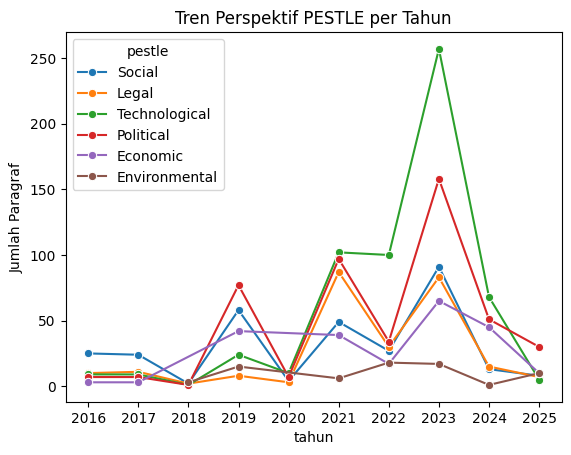

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=trend,
    x="tahun",
    y="count",
    hue="pestle",
    marker="o"
)
plt.title("Tren Perspektif PESTLE per Tahun")
plt.ylabel("Jumlah Paragraf")
plt.show()
